<a href="https://colab.research.google.com/github/Maliha861/Maliha_WeatherWise-Assignment/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


## 📦 Setup and Configuration
Import required packages and setup environment.

In [1]:
# Install required packages
!pip install requests matplotlib pyinputplus fetch-my-weather hands-on-ai

In [2]:
# Core imports
import requests                      # API calls to wttr.in
import matplotlib.pyplot as plt      # Visualisations (line and bar charts)
import pyinputplus as pyip           # Interactive CLI menu
import re                            # Simple NLP parsing
import json                          # Pretty-printing JSON (testing/debug)
import sys                           # Environment/version checks

# Jupyter display
%matplotlib inline

# Global constants (aligned with rubric and wttr.in capabilities)
WTTR_BASE = "https://wttr.in"        # Base API URL
DEFAULT_LOCATION = "Perth"           # Default city
DEFAULT_FORECAST_DAYS = 3            # wttr.in JSON provides up to 3 days
UNITS = "m"                          # "m" metric, "u" US, "M" metric + m/s wind

# Environment check
print("Environment setup complete.")
print("Python version:", sys.version.split()[0])
print("Imports OK: requests, matplotlib, pyinputplus, re, json")

Environment setup complete.
Python version: 3.12.12
Imports OK: requests, matplotlib, pyinputplus, re, json


## 🌤️ Weather Data Functions

In [3]:
# Weather Data Functions — get_weather_data (with small TTL cache)

import time
import requests

# Tiny in-memory TTL cache (bonus-friendly, keeps API calls down)
class _TTLCache:
    def __init__(self):
        self._store = {}  # key -> (expires_at, value)
    def get(self, key):
        rec = self._store.get(key)
        if not rec:
            return None
        expires_at, value = rec
        if time.time() >= expires_at:
            self._store.pop(key, None)
            return None
        return value
    def set(self, key, value, ttl=600):
        self._store[key] = (time.time() + ttl, value)

WEATHER_CACHE = _TTLCache()
_CACHE_TTL_SECONDS = 600  # 10 minutes

def _safe_int(x, default=None):
    try: return int(x)
    except Exception: return default

def _safe_float(x, default=None):
    try: return float(x)
    except Exception: return default

def get_weather_data(location, forecast_days=3, units="m"):
    """
    Retrieve weather data for a specified location from wttr.in and normalise it.

    Args:
        location (str): City or location name.
        forecast_days (int): 1–3 (wttr.in JSON provides up to 3 days).
        units (str): "m" metric, "u" US, "M" metric + m/s wind.

    Returns:
        dict: {
          "location": str,
          "current": {...},
          "forecast": [ {"date","min_c","max_c","chance_of_rain","precip_mm"}, ... ]
        }
        or {"error": "..."} on failure.
    """
    if not location or not isinstance(location, str) or not location.strip():
        return {"error": "Please provide a valid location name."}
    location = location.strip()

    # Cap days to wttr.in limit
    forecast_days = max(1, min(int(forecast_days), 3))

    # Cache key
    cache_key = (location.lower(), forecast_days, units)
    cached = WEATHER_CACHE.get(cache_key)
    if cached is not None:
        return cached

    base_url = f"{WTTR_BASE}/{location}" if "WTTR_BASE" in globals() else f"https://wttr.in/{location}"
    params = {"format": "j1"}
    if units in ("m", "u", "M"):
        params[units] = ""

    try:
        resp = requests.get(
            base_url,
            params=params,
            timeout=10,
            headers={"User-Agent": "Weather-Advisor/1.0 (Student Project)", "Accept": "application/json"},
        )
        resp.raise_for_status()
        data = resp.json()
    except requests.exceptions.Timeout:
        return {"error": "The weather service took too long to respond. Please try again shortly."}
    except requests.exceptions.ConnectionError:
        return {"error": "Network connection error while contacting the weather service."}
    except requests.exceptions.HTTPError as e:
        code = getattr(e.response, "status_code", "Unknown")
        return {"error": f"Weather service returned an HTTP error (status {code})."}
    except requests.exceptions.RequestException:
        return {"error": "Unexpected network error occurred while fetching weather data."}
    except ValueError:
        return {"error": "Invalid JSON response from wttr.in."}

    # Current conditions
    cc = (data.get("current_condition") or [{}])[0]
    current = {
        "temp_c": _safe_int(cc.get("temp_C")),
        "feels_like_c": _safe_int(cc.get("FeelsLikeC")),
        "condition": ((cc.get("weatherDesc") or [{}])[0].get("value")) or "N/A",
        "humidity": _safe_int(cc.get("humidity")),
        "wind_kmph": _safe_int(cc.get("windspeedKmph")),
        "wind_dir": cc.get("winddir16Point") or "",
        "precip_mm": _safe_float(cc.get("precipMM"), 0.0),
        "uv_index": _safe_int(cc.get("uvIndex")),
    }

    # Forecast (up to 3 days)
    forecast_list = []
    for day in (data.get("weather") or [])[:forecast_days]:
        hourly = day.get("hourly") or []
        chance_of_rain = max((_safe_int(h.get("chanceofrain"), 0) for h in hourly), default=0)
        total_precip = sum((_safe_float(h.get("precipMM"), 0.0) for h in hourly))
        forecast_list.append({
            "date": day.get("date"),
            "min_c": _safe_int(day.get("mintempC")),
            "max_c": _safe_int(day.get("maxtempC")),
            "chance_of_rain": chance_of_rain,
            "precip_mm": round(total_precip, 1),
        })

    if not forecast_list:
        return {"error": "No forecast data returned for this location."}

    result = {"location": location, "current": current, "forecast": forecast_list}

    # Cache store
    WEATHER_CACHE.set(cache_key, result, ttl=_CACHE_TTL_SECONDS)
    return result


In [4]:
# Test the get_weather_data() function (3-day forecast from wttr.in)

import json

weather_data = get_weather_data("Perth", forecast_days=3, units="m")

print("Weather Data (3-Day Forecast):")
print(json.dumps(weather_data, indent=2))


Weather Data (3-Day Forecast):
{
  "location": "Perth",
  "current": {
    "temp_c": 20,
    "feels_like_c": 20,
    "condition": "Partly cloudy",
    "humidity": 56,
    "wind_kmph": 24,
    "wind_dir": "WSW",
    "precip_mm": 0.1,
    "uv_index": 2
  },
  "forecast": [
    {
      "date": "2025-10-18",
      "min_c": 16,
      "max_c": 18,
      "chance_of_rain": 100,
      "precip_mm": 0.5
    },
    {
      "date": "2025-10-19",
      "min_c": 12,
      "max_c": 18,
      "chance_of_rain": 100,
      "precip_mm": 2.6
    },
    {
      "date": "2025-10-20",
      "min_c": 11,
      "max_c": 16,
      "chance_of_rain": 100,
      "precip_mm": 3.3
    }
  ]
}


## 📊 Visualisation Functions

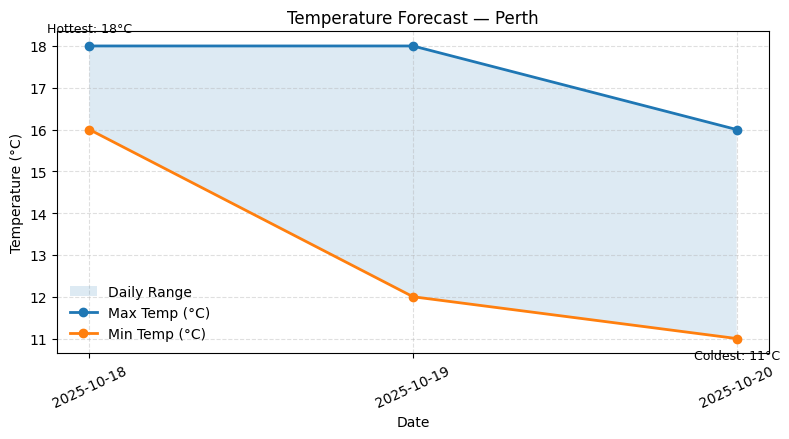

In [10]:
# create_temperature_visualisation()

import math
import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a clean, readable temperature visualisation (min/max °C line chart).
    Adds shaded range and annotations for clarity.
    """
    # Validate input
    if not isinstance(weather_data, dict):
        raise TypeError("weather_data must be a dict as returned by get_weather_data().")
    if "error" in weather_data:
        print(weather_data["error"]); return None
    if "forecast" not in weather_data or not weather_data["forecast"]:
        print("No forecast data available to plot."); return None

    # Extract data safely
    dates, mins, maxs = [], [], []
    for d in weather_data["forecast"]:
        dates.append(str(d.get("date", "")))
        try:
            mn = float(d.get("min_temp", d.get("min_c", math.nan)))
            mx = float(d.get("max_temp", d.get("max_c", math.nan)))
        except (TypeError, ValueError):
            mn, mx = math.nan, math.nan
        mins.append(mn)
        maxs.append(mx)

    # Skip if all values invalid
    if all(math.isnan(x) for x in mins+maxs):
        print("No valid temperature data found.")
        return None

    # Build figure
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.fill_between(dates, mins, maxs, alpha=0.15, label="Daily Range")
    ax.plot(dates, maxs, marker="o", linewidth=2, label="Max Temp (°C)")
    ax.plot(dates, mins, marker="o", linewidth=2, label="Min Temp (°C)")

    # Titles & labels
    ax.set_title(f"Temperature Forecast — {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")

    # Grid & style tweaks
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(frameon=False)
    plt.xticks(rotation=25)
    plt.tight_layout()

    # Optional annotations
    try:
        hottest = max(maxs)
        coldest = min(mins)
        hot_day = dates[maxs.index(hottest)]
        cold_day = dates[mins.index(coldest)]
        ax.annotate(f"Hottest: {hottest:.0f}°C", xy=(hot_day, hottest),
                    xytext=(0, 10), textcoords="offset points", ha="center", fontsize=9)
        ax.annotate(f"Coldest: {coldest:.0f}°C", xy=(cold_day, coldest),
                    xytext=(0, -15), textcoords="offset points", ha="center", fontsize=9)
    except Exception:
        pass

    if output_type == 'figure':
        return fig
    plt.show()
    plt.close(fig)
    return None

    # --- Example test cell ---
wd = get_weather_data("Perth", forecast_days=3)
fig = create_temperature_visualisation(wd, output_type='figure')
if fig:
    plt.figure(fig.number)
    plt.show()

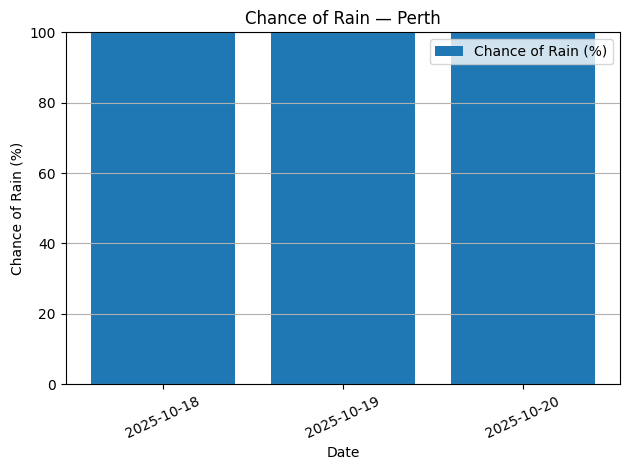

In [8]:
# Define create_precipitation_visualisation() here

import matplotlib.pyplot as plt

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data (Chance of Rain % bar chart).

    Args:
        weather_data (dict): The processed weather data from get_weather_data()
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib Figure object.
        Otherwise, displays the visualisation in the notebook and returns None.
    """
    # Basic validation
    if not isinstance(weather_data, dict):
        raise TypeError("weather_data must be a dict as returned by get_weather_data().")
    if "error" in weather_data:
        print(weather_data["error"]); return None
    if "forecast" not in weather_data or not weather_data["forecast"]:
        print("No forecast data available to plot."); return None

    # Extract series (safe casting + clamp 0..100)
    dates = [str(d.get("date", "")) for d in weather_data["forecast"]]
    chances = []
    for d in weather_data["forecast"]:
        v = d.get("chance_of_rain", 0) or 0
        try:
            v = int(v)
        except Exception:
            v = 0
        chances.append(max(0, min(v, 100)))

    # Build figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(dates, chances)

    # Titles/labels/legend/grid (rubric)
    ax.set_title(f"Chance of Rain — {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y')
    ax.legend(["Chance of Rain (%)"])

    # Readability
    plt.xticks(rotation=25)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    plt.show(); plt.close(fig); return None

wd = get_weather_data("Perth", forecast_days=3, units="m")
fig = create_precipitation_visualisation(wd, output_type='figure')
if fig:
    plt.figure(fig.number)
    plt.show()

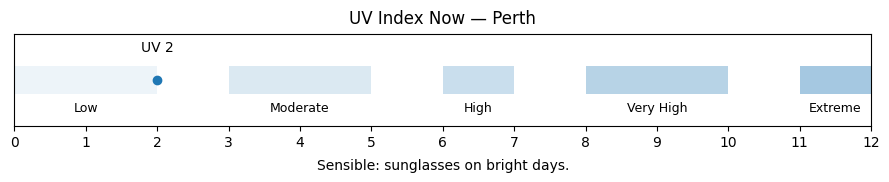

In [13]:
# ONE-CELL: UV Risk Gauge (WHO categories) — uses current['uv_index']

import matplotlib.pyplot as plt

def create_uv_visualisation(weather_data, output_type='display'):
    """
    Visualise current UV index on a horizontal gauge with WHO risk bands and brief advice.
    Expects: weather_data['current']['uv_index'] (number).
    """
    # Validate
    if not isinstance(weather_data, dict):
        raise TypeError("weather_data must be a dict as returned by get_weather_data().")
    if "error" in weather_data:
        print(weather_data["error"]); return None
    cur = weather_data.get("current") or {}
    if "uv_index" not in cur:
        print("No UV index available in current conditions."); return None

    # UV value (clamped to 0–12 to cover '11+')
    try:
        uv = float(cur["uv_index"])
    except (TypeError, ValueError):
        print("UV index is not numeric."); return None
    uv = max(0.0, min(uv, 12.0))

    # WHO bands: (low, high, label)
    bands = [
        (0, 2,   "Low"),
        (3, 5,   "Moderate"),
        (6, 7,   "High"),
        (8, 10,  "Very High"),
        (11, 12, "Extreme")
    ]

    def label_for(v):
        for lo, hi, name in bands:
            if lo <= v <= hi:
                return name
        return "Extreme"

    advice = {
        "Low": "Sensible: sunglasses on bright days.",
        "Moderate": "SPF 30+, hat, sunglasses; seek shade at midday.",
        "High": "SPF 50+, cover up; shade 10–4.",
        "Very High": "SPF 50+, cover up; reapply often.",
        "Extreme": "Avoid midday sun; SPF 50+; cover up.",
    }[label_for(uv)]

    # Figure
    fig, ax = plt.subplots(figsize=(9, 2.2))

    # Shaded risk bands (no custom colors, just alpha)
    for i, (lo, hi, name) in enumerate(bands, start=1):
        ax.axvspan(lo, hi, ymin=0.35, ymax=0.65, alpha=0.08 * i)
        ax.text((lo + hi) / 2, 0.2, name, ha='center', va='center', fontsize=9)

    # Axis styling
    ax.set_xlim(0, 12)
    ax.set_xticks(range(0, 13))
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    # Marker for current UV
    ax.plot([uv], [0.5], marker='o')
    ax.text(uv, 0.78, f"UV {uv:.0f}", ha='center', va='bottom', fontsize=10)

    # Titles + advice
    ax.set_title(f"UV Index Now — {weather_data.get('location','')}", pad=8)
    ax.text(0.5, -0.35, advice, ha='center', va='top', fontsize=10, transform=ax.transAxes)

    plt.tight_layout()
    if output_type == 'figure':
        return fig
    plt.show(); plt.close(fig)
    return None


# --- RUN IT NOW ---
wd = get_weather_data("Perth", forecast_days=3)
create_uv_visualisation(wd, output_type='display')

## 🤖 Natural Language Processing

In [11]:
# Natural Language Processing

import re

# --- Internal helpers for NLP ---

_ATTR_ALIASES = {
    "rain": ["rain", "precip", "precipitation", "shower", "wet"],
    "temperature": ["temp", "temperature", "hot", "cold", "warm", "cool", "heat"],
    "wind": ["wind", "breeze", "gust"],
    "humidity": ["humidity", "humid"],
}

def _detect_attribute(q: str) -> str | None:
    ql = q.lower()
    for key, words in _ATTR_ALIASES.items():
        if any(w in ql for w in words):
            return key
    return None

def _detect_days_and_when(q: str) -> tuple[int, str]:
    """
    Returns (days, when_label)
      when_label in {"today","tomorrow","next"}
      days is clamped to 1..3 (wttr.in returns up to 3 days)
    """
    ql = q.lower()
    if "today" in ql:
        return (1, "today")
    if "tomorrow" in ql:
        return (2, "tomorrow")  # ensures index 1 is available in responder

    # Allow "next N day" or "next N days"
    m = re.search(r"\bnext\s+(\d+)\s+day(?:s)?\b", ql)
    if m:
        n = int(m.group(1))
        return (max(1, min(n, 3)), "next")

    # default window
    return (3, "next")

def _detect_location(q: str, fallback: str | None = None) -> str | None:
    """
    Extract a simple location after 'in' or 'for'.
    Example: 'Will it rain tomorrow in Perth?' -> 'Perth'
    """
    m = re.search(r"\b(?:in|for)\s+([A-Za-z][A-Za-z\s,.'-]{1,48})\b", q, re.IGNORECASE)
    if m:
        return m.group(1).strip()
    return fallback

# --- Public API ---

def parse_weather_question(question: str, default_location: str | None = None) -> dict:
    """
    Parse a natural-language weather question into structured intent.

    Returns:
        dict with keys:
          "location": str|None,
          "days": int (1..3),
          "attribute": "rain"|"temperature"|"wind"|"humidity"|None,
          "when": "today"|"tomorrow"|"next"
    """
    if not question or not isinstance(question, str):
        return {"error": "Please provide a question string."}

    attribute = _detect_attribute(question)
    days, when = _detect_days_and_when(question)
    # Use provided default or global DEFAULT_LOCATION if available
    fallback_loc = default_location or globals().get("DEFAULT_LOCATION")
    location = _detect_location(question, fallback=fallback_loc)

    # Clamp defensively
    days = max(1, min(int(days), 3))

    return {"location": location, "days": days, "attribute": attribute, "when": when}

def generate_weather_response(parsed: dict, weather_data: dict) -> str:
    """
    Generate a concise, human-readable answer from parsed intent and weather data.
    """
    if not parsed or ("error" in parsed):
        return parsed.get("error", "I couldn't understand the question.")
    if not weather_data or ("error" in weather_data):
        return weather_data.get("error", "I couldn't retrieve weather data.")

    loc = weather_data.get("location") or parsed.get("location") or "the requested location"
    when = parsed.get("when", "next")
    attr = parsed.get("attribute")

    fcast = weather_data.get("forecast", [])
    if not fcast:
        return f"No forecast data available for {loc}."

    # Select forecast window
    if when == "today":
        window = fcast[:1]
    elif when == "tomorrow":
        window = fcast[1:2] if len(fcast) >= 2 else fcast[:1]
    else:
        window = fcast[:max(1, min(parsed.get("days", len(fcast)), len(fcast)))]

    # Aggregations (defensive)
    def _min_val(k):
        vals = [d.get(k) for d in window if d.get(k) is not None]
        return min(vals) if vals else None

    def _max_val(k):
        vals = [d.get(k) for d in window if d.get(k) is not None]
        return max(vals) if vals else None

    def _sum_val(k):
        vals = [d.get(k) or 0 for d in window]
        return sum(vals) if vals else 0

    hi = _max_val("max_c")
    lo = _min_val("min_c")
    rainp = _max_val("chance_of_rain")
    precip = _sum_val("precip_mm")

    # Attribute-specific responses
    if attr == "rain":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            rp = window[0].get("chance_of_rain")
            pm = window[0].get("precip_mm")
            rp_txt = f"{rp}%" if rp is not None else "unknown"
            pm_txt = f"{pm} mm" if pm is not None else "unknown"
            return f"In {loc} ({d0}), chance of rain is {rp_txt}, expected precipitation {pm_txt}."
        rp_txt = f"{rainp}%" if rainp is not None else "unknown"
        return (f"In {loc} over the next {len(window)} day(s), the maximum chance of rain is "
                f"{rp_txt} with a total of {precip:.1f} mm expected.")

    if attr == "temperature":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            return f"In {loc} ({d0}), expect a high near {hi}°C and a low around {lo}°C."
        return (f"In {loc} over the next {len(window)} day(s), highs up to ~{hi}°C "
                f"and lows down to ~{lo}°C.")

    if attr == "wind":
        c = weather_data.get("current", {})
        ws = c.get("wind_kmph")
        wd = c.get("wind_dir", "")
        if ws is not None:
            return f"In {loc} {when}, current winds are about {ws} km/h {wd}."
        return f"In {loc} {when}, wind information is not available."

    if attr == "humidity":
        c = weather_data.get("current", {})
        h = c.get("humidity")
        if h is not None:
            return f"In {loc} {when}, current humidity is approximately {h}%."
        return f"In {loc} {when}, humidity information is not available."

    # Generic fallback
    cond = (weather_data.get("current") or {}).get("condition", "").lower() or "current conditions"
    if len(window) == 1:
        d0 = window[0].get("date", "the day")
        return (f"In {loc} ({d0}), it is {cond} with a high near {hi}°C, low around {lo}°C, "
                f"and up to {rainp if rainp is not None else 'unknown'}% chance of rain (≈{precip:.1f} mm total).")
    return (f"In {loc} over the next {len(window)} day(s), expect {cond}, highs up to ~{hi}°C, "
            f"lows near ~{lo}°C, and up to {rainp if rainp is not None else 'unknown'}% chance of rain (≈{precip:.1f} mm total).")


## 🧭 User Interface

In [12]:
# User Interface
# --------------

import pyinputplus as pyip

def _print_welcome(app_name="Weather Advisor", user_name=None, location=None, units="m", forecast_days=3):
    title = f"🌤️  Welcome to {app_name}" if not user_name else f"🌤️  Welcome to {app_name}, {user_name}"
    print("\n" + title)
    print("=" * len(title))
    unit_label = {"m": "Metric (°C, km/h)", "u": "US (°F, mph)", "M": "Metric (°C, m/s)"}.get(units, units)
    parts = []
    if location:
        parts.append(f"Location: {location}")
    parts.append(f"Units: {unit_label}")
    parts.append(f"Forecast days: {forecast_days}")
    print(" | ".join(parts) + "\n")

def _print_current(weather_data: dict) -> None:
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print(weather_data.get("error", "No data available."))
        return
    cur = weather_data.get("current", {}) or {}
    print(f"\nCurrent weather — {weather_data.get('location','')}")
    print(f"  Condition : {cur.get('condition','N/A')}")
    print(f"  Temp      : {cur.get('temp_c','?')}°C (feels {cur.get('feels_like_c','?')}°C)")
    print(f"  Humidity  : {cur.get('humidity','?')}%")
    print(f"  Wind      : {cur.get('wind_kmph','?')} km/h {cur.get('wind_dir','')}")
    print(f"  Precip    : {cur.get('precip_mm','?')} mm")
    print(f"  UV Index  : {cur.get('uv_index','?')}\n")

def _print_forecast(weather_data: dict) -> None:
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print(weather_data.get("error", "No data available."))
        return
    rows = weather_data.get("forecast", []) or []
    if not rows:
        print("No forecast data available.")
        return
    print(f"\nForecast — {weather_data.get('location','')}")
    print("  Date         Min °C   Max °C   Rain%   Precip (mm)")
    print("  ---------------------------------------------------")
    for d in rows:
        date = str(d.get('date','YYYY-MM-DD')).ljust(12)
        mn   = str(d.get('min_c','?')).rjust(6)
        mx   = str(d.get('max_c','?')).rjust(8)
        rp   = str(d.get('chance_of_rain','?')).rjust(7)
        mm   = str(d.get('precip_mm','?')).rjust(12)
        print(f"  {date}{mn}{mx}{rp}{mm}")
    print("")

def main_menu(default_location: str = "Perth") -> None:
    """
    Interactive CLI menu for Weather Advisor.
    Requires:
      - get_weather_data()
      - create_temperature_visualisation()
      - create_precipitation_visualisation()
      - parse_weather_question()
      - generate_weather_response()
    """
    location = (default_location or globals().get("DEFAULT_LOCATION") or "Perth").strip()
    units = (globals().get("UNITS") or "m")
    forecast_days = 3  # wttr.in returns up to 3 days

    user_name = pyip.inputStr("Enter your name (optional, press Enter to skip): ", blank=True)
    _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)

    while True:
        choice = pyip.inputMenu(
            [
                "Set/Change location",
                "Show current conditions",
                "Show forecast + charts",
                "Ask a weather question",
                "Settings",
                "Exit",
            ],
            numbered=True
        )

        if choice == "Set/Change location":
            loc = pyip.inputStr("Enter city/suburb (e.g., Perth): ").strip()
            if loc:
                location = loc
                print(f"Location set to: {location}")
                _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)
            else:
                print("Location unchanged.")

        elif choice == "Show current conditions":
            data = get_weather_data(location, forecast_days=1, units=units)
            _print_current(data)

        elif choice == "Show forecast + charts":
            data = get_weather_data(location, forecast_days=forecast_days, units=units)
            if isinstance(data, dict) and "error" not in data:
                _print_forecast(data)
                create_temperature_visualisation(data)
                create_precipitation_visualisation(data)
            else:
                print(data.get("error", data))

        elif choice == "Ask a weather question":
            q = pyip.inputStr("Enter your question (e.g., 'Will it rain tomorrow in Perth?'): ").strip()
            if not q:
                print("Please enter a question.")
                continue
            parsed = parse_weather_question(q, default_location=location)
            loc_for_query = parsed.get("location") or location
            days_for_query = parsed.get("days", 3)
            data = get_weather_data(loc_for_query, forecast_days=days_for_query, units=units)
            print("\n" + generate_weather_response(parsed, data) + "\n")

        elif choice == "Settings":
            units_choice = pyip.inputMenu(
                ["m (metric °C, km/h)", "u (US °F, mph)", "M (metric+wind m/s)"],
                numbered=True
            )
            units = units_choice.split()[0]
            forecast_days = pyip.inputInt("Forecast days (1–3): ", min=1, max=3)
            print(f"Units set to: {units} | Forecast days set to: {forecast_days}")
            _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)

        else:  # Exit
            print("Exiting Weather Advisor.")
            break

Enter your name (optional, press Enter to skip): Maliha

🌤️  Welcome to Weather Advisor, Maliha
Location: Perth | Units: Metric (°C, km/h) | Forecast days: 3

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
1
Enter city/suburb (e.g., Perth): Cannington
Location set to: Cannington

🌤️  Welcome to Weather Advisor, Maliha
Location: Cannington | Units: Metric (°C, km/h) | Forecast days: 3

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
3

Forecast — Cannington
  Date         Min °C   Max °C   Rain%   Precip (mm)
  ---------------------------------------------------
  2025-10-04      13      21    100         3.5
  2025-10-05      11      16    100         0.3
  2025-10-06      10      21      0         0.0



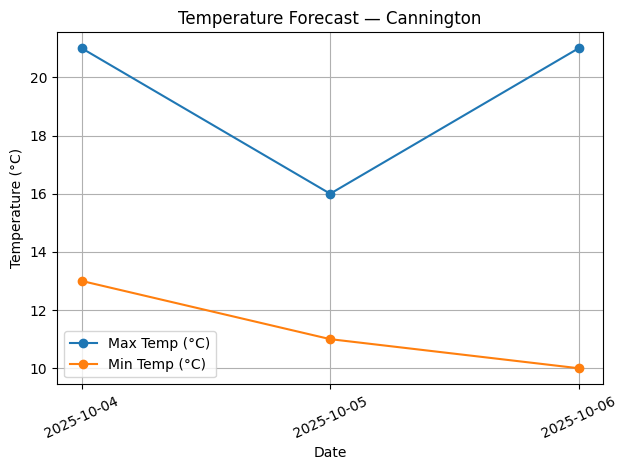

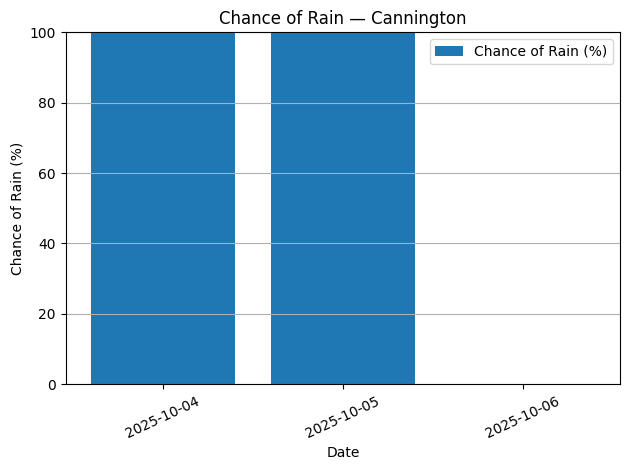

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
4
Enter your question (e.g., 'Will it rain tomorrow in Perth?'): Will it be sunny tomorrow?

In Cannington (2025-10-05), it is light rain with a high near 16°C, low around 11°C, and up to 100% chance of rain (≈0.3 mm total).

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
Thanks.
'Thanks.' is not a valid choice.
Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
6
Exiting Weather Advisor.


In [ ]:
# To start the interactive menu, run:
main_menu("Perth")

## 🧩 Main Application Logic

In [ ]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response from parsed intent and normalised weather data.
    """
    # Basic validation
    if not isinstance(parsed_question, dict) or not parsed_question:
        return "I couldn't understand the question."
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return weather_data.get("error", "Sorry, I couldn't retrieve weather data.")

    loc = weather_data.get("location") or parsed_question.get("location") or "the requested location"
    when = parsed_question.get("when", "next")
    attr = parsed_question.get("attribute")

    forecast = weather_data.get("forecast") or []
    if not forecast:
        return f"No forecast data available for {loc}."

    # Select the time window
    if when == "today":
        window = forecast[:1]
    elif when == "tomorrow":
        window = forecast[1:2] if len(forecast) >= 2 else forecast[:1]
    else:  # "next" or unspecified
        n = parsed_question.get("days", len(forecast))
        window = forecast[:max(1, min(n, len(forecast)))]

    # Aggregation helpers
    def _vals(key):
        return [d.get(key) for d in window if d.get(key) is not None]

    def _min(key):
        v = _vals(key);  return min(v) if v else None

    def _max(key):
        v = _vals(key);  return max(v) if v else None

    def _sum(key):
        return sum((d.get(key) or 0) for d in window)

    hi = _max("max_c")
    lo = _min("min_c")
    rainp_max = _max("chance_of_rain")
    precip_sum = _sum("precip_mm")

    # Attribute-specific responses
    if attr == "rain":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            rp = window[0].get("chance_of_rain")
            pm = window[0].get("precip_mm")
            rp_txt = f"{rp}%" if rp is not None else "unknown"
            pm_txt = f"{pm:.1f} mm" if isinstance(pm, (int, float)) else "unknown"
            return f"In {loc} ({d0}), chance of rain is {rp_txt}, expected precipitation {pm_txt}."
        rp_txt = f"{rainp_max}%" if rainp_max is not None else "unknown"
        return (f"In {loc} over the next {len(window)} day(s), the maximum chance of rain is "
                f"{rp_txt} with a total of {precip_sum:.1f} mm expected.")

    if attr == "temperature":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            return f"In {loc} ({d0}), expect a high near {hi}°C and a low around {lo}°C."
        return (f"In {loc} over the next {len(window)} day(s), highs up to ~{hi}°C "
                f"and lows down to ~{lo}°C.")

    if attr == "wind":
        cur = weather_data.get("current") or {}
        ws = cur.get("wind_kmph")
        wd = cur.get("wind_dir", "")
        if ws is not None:
            return f"In {loc} {when}, current winds are about {ws} km/h {wd}."
        return f"In {loc} {when}, wind information is not available."

    if attr == "humidity":
        cur = weather_data.get("current") or {}
        h = cur.get("humidity")
        if h is not None:
            return f"In {loc} {when}, current humidity is approximately {h}%."
        return f"In {loc} {when}, humidity information is not available."

    # Generic fallback summary
    cond = (weather_data.get("current") or {}).get("condition", "current conditions").lower()
    if len(window) == 1:
        d0 = window[0].get("date", "the day")
        rp_txt = f"{rainp_max}%" if rainp_max is not None else "unknown"
        return (f"In {loc} ({d0}), it is {cond} with a high near {hi}°C, low around {lo}°C, "
                f"and up to {rp_txt} chance of rain (≈{precip_sum:.1f} mm total).")
    rp_txt = f"{rainp_max}%" if rainp_max is not None else "unknown"
    return (f"In {loc} over the next {len(window)} day(s), expect {cond}, highs up to ~{hi}°C, "
            f"lows near ~{lo}°C, and up to {rp_txt} (≈{precip_sum:.1f} mm total).")


## 🧪 Testing and Examples

In [ ]:
# Test 1 — Weather Data API
import json

print("Test 1: get_weather_data (Perth, 3 days, metric)")
data_ok = get_weather_data("Perth", forecast_days=3, units="m")
if isinstance(data_ok, dict) and "error" not in data_ok:
    print("OK:", list(data_ok.keys()))
    print("Forecast length:", len(data_ok.get("forecast", [])))
    print("Sample day:", data_ok["forecast"][0] if data_ok.get("forecast") else "N/A")
else:
    print("Error:", data_ok)

Test 1: get_weather_data (Perth, 3 days, metric)
OK: ['location', 'current', 'forecast']
Forecast length: 3
Sample day: {'date': '2025-10-04', 'min_c': 15, 'max_c': 21, 'chance_of_rain': 100, 'precip_mm': 4.4}


In [ ]:
# Test 2 — Weather Data API (invalid input)

print("Test 2: get_weather_data (empty location)")
data_bad_input = get_weather_data("", forecast_days=3, units="m")
print(data_bad_input)


Test 2: get_weather_data (empty location)
{'error': 'Please provide a valid location name.'}


In [ ]:
# Test 3 — Weather Data API (unlikely location)

print("Test 3: get_weather_data ('Xxxyville')")
data_weird = get_weather_data("Xxxyville", forecast_days=3, units="m")
print("Type:", type(data_weird).__name__)
print(data_weird if "error" in data_weird else {"location": data_weird.get("location"),
                                                "forecast_len": len(data_weird.get("forecast", []))})


Test 3: get_weather_data ('Xxxyville')
Type: dict
{'error': 'Weather service returned an HTTP error (status 404).'}


Test 4: Visualisations for Perth (3-day)


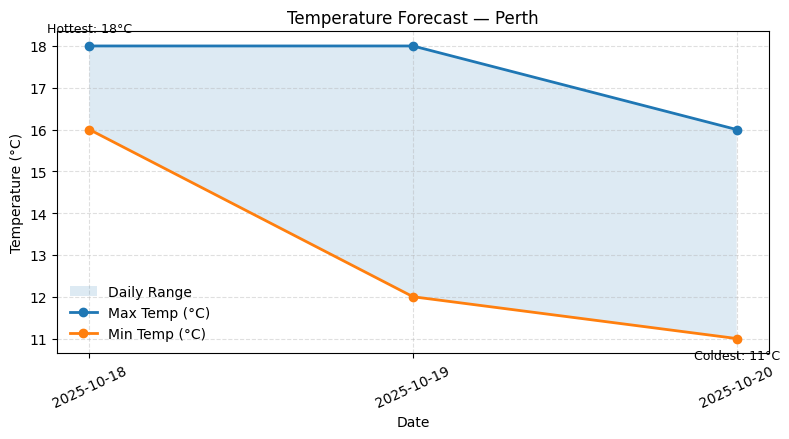

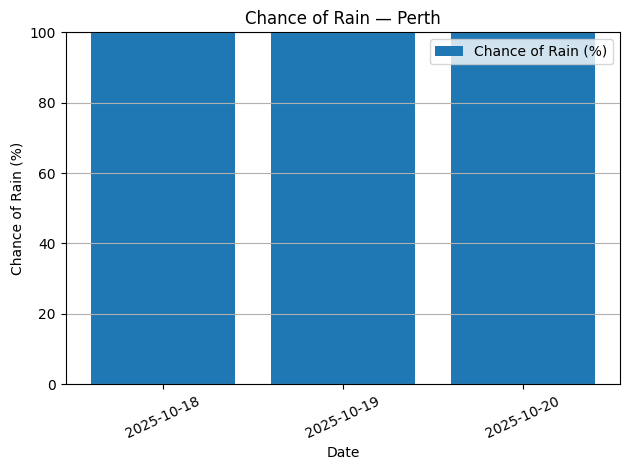

In [14]:
# Test 4 — Visualisations (live data)

print("Test 4: Visualisations for Perth (3-day)")
wd_viz = get_weather_data("Perth", forecast_days=3, units="m")
if isinstance(wd_viz, dict) and "error" not in wd_viz:
    create_temperature_visualisation(wd_viz, output_type='display')
    create_precipitation_visualisation(wd_viz, output_type='display')
else:
    print("Skipped visualisations:", wd_viz)

In [15]:
# Test 5 — NLP parsing examples

print("Test 5: parse_weather_question samples")
samples = [
    "Will it rain tomorrow in Perth?",
    "What is the temperature today?",
    "Wind next 3 days for Perth",
    "Humidity in Fremantle",
    "Rain in Perth next 2 days"
]
for q in samples:
    parsed = parse_weather_question(q, default_location="Perth")
    print("Q:", q)
    print("Parsed:", parsed)
    print()


Test 5: parse_weather_question samples
Q: Will it rain tomorrow in Perth?
Parsed: {'location': 'Perth', 'days': 2, 'attribute': 'rain', 'when': 'tomorrow'}

Q: What is the temperature today?
Parsed: {'location': 'Perth', 'days': 1, 'attribute': 'temperature', 'when': 'today'}

Q: Wind next 3 days for Perth
Parsed: {'location': 'Perth', 'days': 3, 'attribute': 'wind', 'when': 'next'}

Q: Humidity in Fremantle
Parsed: {'location': 'Fremantle', 'days': 3, 'attribute': 'humidity', 'when': 'next'}

Q: Rain in Perth next 2 days
Parsed: {'location': 'Perth next', 'days': 2, 'attribute': 'rain', 'when': 'next'}



In [16]:
# Test 6 — End-to-end Q&A (parse -> fetch -> respond)

print("Test 6: End-to-end Q&A")
q = "Will it rain tomorrow in Perth?"
parsed = parse_weather_question(q, default_location="Perth")
wd = get_weather_data(parsed.get("location", "Perth"), forecast_days=parsed.get("days", 3), units="m")
resp = generate_weather_response(parsed, wd)
print("Question:", q)
print("Response:", resp)


Test 6: End-to-end Q&A
Question: Will it rain tomorrow in Perth?
Response: In Perth (2025-10-19), chance of rain is 100%, expected precipitation 2.6 mm.


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.